In [1]:
import unicodedata
from pathlib import Path
import lightgbm as lgb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder

In [2]:
INPUT_DIR = Path("data/")

In [28]:
train_df = pd.read_csv(INPUT_DIR / "train.csv")
test_df = pd.read_csv(INPUT_DIR / "test.csv")
sub_df = pd.read_csv(INPUT_DIR / "submit_sample.csv", names=["id", "price"])

In [30]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # cylinderから数値を取り出す
        X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")

        # sizeの表記揺れを修正
        size_dict = {'mid-size':3, 'full-size':4, 'sub-compact':1, 'compact':2}
        X["size"] = X["size"].str.replace("ー", "-").astype(str)
        X["size"] = X["size"].str.replace("−", "-").astype(str)
        X["size"] = X["size"].apply(lambda x: size_dict[x])

        # conditionをランクづけ
        condition_dict = {'excellent':4, 'fair':2, 'good':3, 'like new':5, 'salvage':1, 'new':6}
        X['condition'] = X['condition'].apply(lambda x: condition_dict[x])

        # manufacturerの表記揺れを修正
        X["manufacturer"] = X["manufacturer"].apply(
            lambda x: unicodedata.normalize("NFKC", x).lower()
        )

        # yearが3000年以降のものはおかしいので2000年に置換
        X.loc[X['year']>2030, "year"] -= 1000

        # odometerの外れ値を10で割る
        X['odometer'] = X['odometer'].apply(abs)
        X['odometer'] = [x//10 if x>10e6 else x for x in X['odometer'].values]

        # 走行距離 / 製造年
        X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

        return X


class RankTransformer(TransformerMixin, BaseEstimator):
    """keyの中でvalueが何番目のものか"""

    def __init__(self, key: str, value: str):
        self.key = key
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new[self.key] = X_new.groupby(self.key)[self.value].rank(method="dense")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return [self.key]


class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols


class CountTransformer(TransformerMixin, BaseEstimator):
    """CountEncoder"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.ce = CountEncoder(cols=X.columns.tolist(), handle_unknown=0)
        self.ce.fit(X)
        return self

    def transform(self, X):
        return self.ce.transform(X)

    def get_feature_names_out(self, input_features=None):
        return input_features


class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [32]:
#PreProcessTransformer().transform(train_df)
#train_df

In [33]:
numeric_cols = ["year", "size", "condition", "odometer", "odometer_per_year"]
categorical_cols = [
    #  'region',
    "cylinders",
    "manufacturer",
    # "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    # "size",
    "type",
    "paint_color",
    "state",
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            categorical_cols,
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.0s


In [34]:
train_feat_df.sample(5)

,ori__year,ori__size,ori__condition,ori__odometer,ori__odometer_per_year,ori__cylinders,ori__manufacturer,ori__fuel,ori__title_status,ori__transmission,...,ori__state,tgt__cylinders,tgt__manufacturer,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__type,tgt__paint_color,tgt__state
4210,1985.0,4.0,4.0,57206.0,1505.421021,8.0,ford,gas,clean,manual,...,ca,16300.143568,14722.428347,12214.504336,13225.978879,11895.073699,18561.626916,13736.755841,14685.067166,13532.993457
13565,1991.0,4.0,3.0,209035.0,6532.343750,4.0,nissan,diesel,clean,manual,...,fl,10498.983321,9970.877123,24678.611486,13225.978879,11895.073699,9818.321203,20097.961340,13426.587474,12512.123556
21503,2001.0,4.0,4.0,171610.0,7800.454590,8.0,chevrolet,gas,clean,automatic,...,NaN,16555.010161,15159.697150,12282.452422,13371.433337,14025.651486,15815.212934,20346.051716,16959.000860,13875.105404
11210,2013.0,4.0,4.0,137306.0,13730.599609,8.0,ford,gas,clean,automatic,...,NaN,16300.143568,14722.428347,12214.504336,13225.978879,13910.841120,9818.321203,13736.755841,11320.869501,13745.764216
11245,2017.0,2.0,5.0,64250.0,10708.333008,4.0,volkswagen,gas,rebuilt,automatic,...,tx,10531.256081,8186.714740,12240.361505,14888.903124,13943.426349,9767.130897,9860.993469,14828.422588,12767.385565


In [35]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(100, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [37]:
n_fold = 5
lgbm_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 5,
    "num_leaves": 32,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
    "verbosity":-1
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=n_fold)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df) for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv("output/sub004.csv", index=False, header=False)

 - fold1 - 0.4478
 - fold2 - 0.4383
 - fold3 - 0.4443
 - fold4 - 0.4446
 - fold5 - 0.4403
FINISHI: Whole Score: 0.4431


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


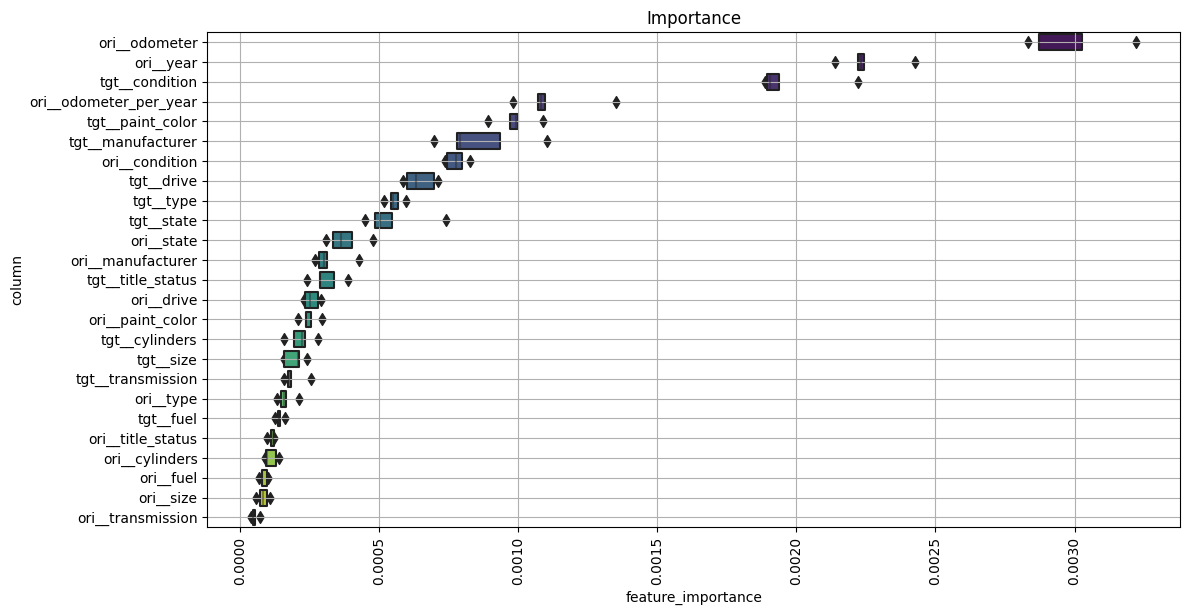

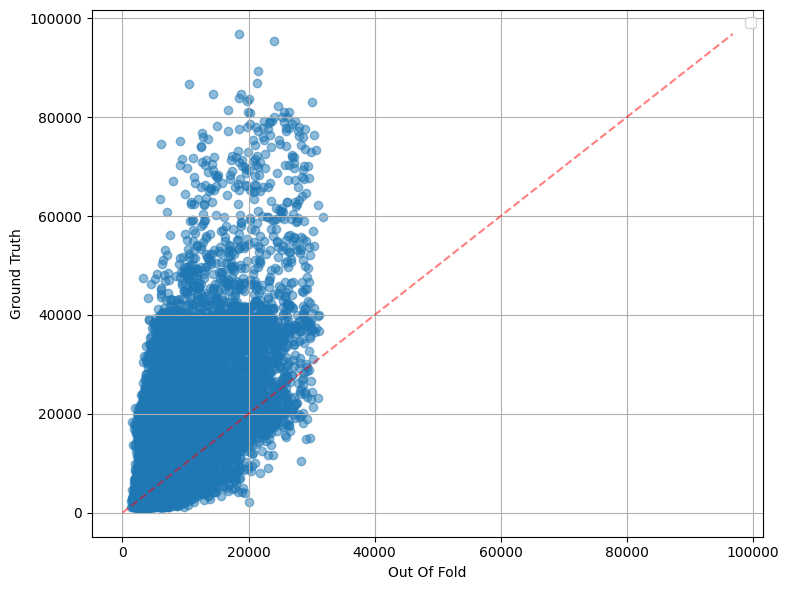

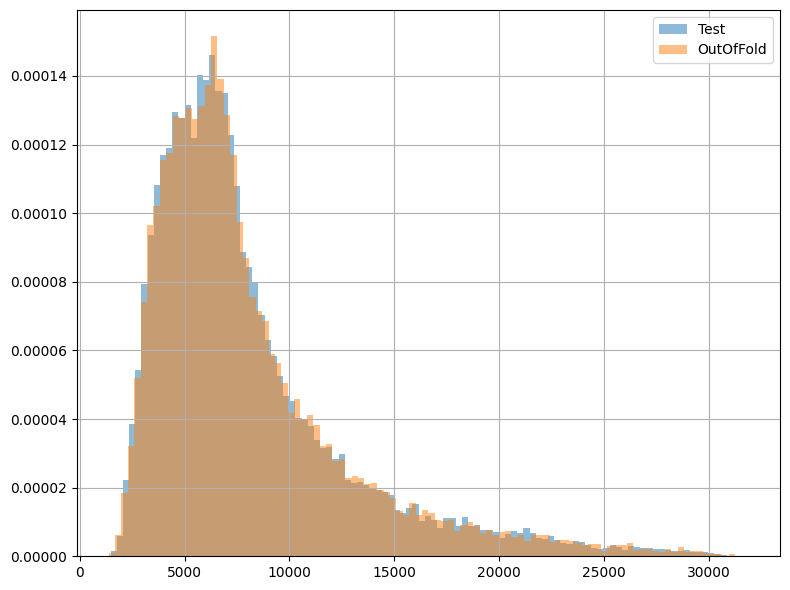

In [14]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)